In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np


train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_dir='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  
test_datagen = ImageDataGenerator(rescale=1./255)
# Create the training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

# Create the validation generator from the training data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


num_classes = len(train_generator.class_indices)

Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [15]:
def create_simple_cnn(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(38, activation='softmax')
    ])
    return model


In [16]:
def create_resnet(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(38, activation='softmax')
    ])
    return model

In [17]:
def create_vgg16(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(38, activation='softmax')
    ])
    return model

In [18]:
def compile_and_train_model(model, train_gen, val_gen, epochs=3):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping])
    return history

In [19]:
def evaluate_model_train_test(model, train_gen, test_gen):
    
    train_loss, train_accuracy = model.evaluate(train_gen)
    y_train_pred = model.predict(train_gen)
    y_train_true = train_gen.classes
    y_train_pred_flat = np.argmax(y_train_pred, axis=1)
    train_report = classification_report(y_train_true, y_train_pred_flat, output_dict=True)

    
    test_loss, test_accuracy = model.evaluate(test_gen)
    y_test_pred = model.predict(test_gen)
    y_test_true = test_gen.classes
    y_test_pred_flat = np.argmax(y_test_pred, axis=1)
    test_report = classification_report(y_test_true, y_test_pred_flat, output_dict=True)

    return train_accuracy, test_accuracy, train_report, test_report

In [20]:
def extract_metrics(report):
    return {
        "Accuracy": report['accuracy'],
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    }

In [21]:
input_shape = (224, 224, 3)


resnet_model = create_resnet(input_shape)
resnet_history = compile_and_train_model(resnet_model, train_generator, validation_generator)
train_accuracy_resnet, test_accuracy_resnet, train_report_resnet, test_report_resnet = evaluate_model_train_test(resnet_model, train_generator, test_generator)

Epoch 1/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 368s 180ms/step - accuracy: 0.7097 - loss: 1.1007 - val_accuracy: 0.8265 - val_loss: 0.5533
Epoch 2/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 296s 168ms/step - accuracy: 0.9446 - loss: 0.1823 - val_accuracy: 0.7703 - val_loss: 0.8021
Epoch 3/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 295s 168ms/step - accuracy: 0.9604 - loss: 0.1272 - val_accuracy: 0.9096 - val_loss: 0.2989
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 110s 63ms/step - accuracy: 0.9279 - loss: 0.2259
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 119s 66ms/step
  1/550 ━━━━━━━━━━━━━━━━━━━━ 1:25 156ms/step - accuracy: 0.9688 - loss: 0.1329

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


550/550 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - accuracy: 0.9421 - loss: 0.1958
550/550 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step


In [22]:
simple_cnn_model = create_simple_cnn(input_shape)
simple_cnn_history = compile_and_train_model(simple_cnn_model, train_generator, validation_generator)
train_accuracy_cnn, test_accuracy_cnn, train_report_cnn, test_report_cnn = evaluate_model_train_test(simple_cnn_model, train_generator, test_generator)

Epoch 1/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 82ms/step - accuracy: 0.4499 - loss: 2.0321 - val_accuracy: 0.4476 - val_loss: 2.0624
Epoch 2/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 139s 79ms/step - accuracy: 0.7621 - loss: 0.7824 - val_accuracy: 0.7039 - val_loss: 0.9699
Epoch 3/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 134s 76ms/step - accuracy: 0.8252 - loss: 0.5613 - val_accuracy: 0.7862 - val_loss: 0.6946
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 110s 62ms/step - accuracy: 0.8406 - loss: 0.4997
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 104s 59ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.7947 - loss: 0.6536
550/550 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step


In [23]:
vgg16_model = create_vgg16(input_shape)
vgg16_history = compile_and_train_model(vgg16_model, train_generator, validation_generator)
train_accuracy_vgg16, test_accuracy_vgg16, train_report_vgg16, test_report_vgg16 = evaluate_model_train_test(vgg16_model, train_generator, test_generator)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 432s 231ms/step - accuracy: 0.1098 - loss: 3.4497 - val_accuracy: 0.2256 - val_loss: 2.7502
Epoch 2/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 384s 218ms/step - accuracy: 0.4523 - loss: 1.8356 - val_accuracy: 0.4780 - val_loss: 1.9397
Epoch 3/3
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 382s 217ms/step - accuracy: 0.6857 - loss: 1.0129 - val_accuracy: 0.6290 - val_loss: 7.8188
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 118s 67ms/step - accuracy: 0.4849 - loss: 3.4028
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 110s 62ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.5068 - loss: 8.6856
550/550 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step


In [24]:
metrics_cnn_train = extract_metrics(train_report_cnn)
metrics_cnn_test = extract_metrics(test_report_cnn)

metrics_resnet_train = extract_metrics(train_report_resnet)
metrics_resnet_test = extract_metrics(test_report_resnet)

metrics_vgg16_train = extract_metrics(train_report_vgg16)
metrics_vgg16_test = extract_metrics(test_report_vgg16)

In [25]:
results = {
    "model": ["Simple CNN", "ResNet", "VGG16"],
    "Accuracy train": [metrics_cnn_train['Accuracy'], metrics_resnet_train['Accuracy'], metrics_vgg16_train['Accuracy']],
    "Accuracy test": [metrics_cnn_test['Accuracy'], metrics_resnet_test['Accuracy'], metrics_vgg16_test['Accuracy']],
    "Precision train": [metrics_cnn_train['Precision'], metrics_resnet_train['Precision'], metrics_vgg16_train['Precision']],
    "Precision test": [metrics_cnn_test['Precision'], metrics_resnet_test['Precision'], metrics_vgg16_test['Precision']],
    "Recall train": [metrics_cnn_train['Recall'], metrics_resnet_train['Recall'], metrics_vgg16_train['Recall']],
    "Recall test": [metrics_cnn_test['Recall'], metrics_resnet_test['Recall'], metrics_vgg16_test['Recall']],
    "F1-score train": [metrics_cnn_train['F1-score'], metrics_resnet_train['F1-score'], metrics_vgg16_train['F1-score']],
    "F1-score test": [metrics_cnn_test['F1-score'], metrics_resnet_test['F1-score'], metrics_vgg16_test['F1-score']],
}

results_df = pd.DataFrame(results)

In [26]:
results_df

,model,Accuracy train,Accuracy test,Precision train,Precision test,Recall train,Recall test,F1-score train,F1-score test
0,Simple CNN,0.026275,0.787958,0.026104,0.833621,0.026275,0.787958,0.025664,0.787490
1,ResNet,0.026702,0.916856,0.026622,0.942237,0.026702,0.916856,0.026384,0.920788
2,VGG16,0.028159,0.477749,0.028247,0.647177,0.028159,0.477749,0.022387,0.451591


In [27]:
import matplotlib.pyplot as plt

def plot_results(results):
    results_df = pd.DataFrame(results)

    
    bar_width = 0.2
    x = np.arange(len(results_df['model']))

    
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))

    
    ax[0].bar(x - bar_width, results_df['Accuracy train'], width=bar_width, label='Train Accuracy')
    ax[0].bar(x, results_df['Accuracy test'], width=bar_width, label='Test Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(results_df['model'])
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].legend()
    
    ax[1].bar(x - bar_width, results_df['F1-score train'], width=bar_width, label='Train F1-Score')
    ax[1].bar(x, results_df['F1-score test'], width=bar_width, label='Test F1-Score')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(results_df['model'])
    ax[1].set_ylabel('F1-Score')
    ax[1].set_title('Model F1-Score Comparison')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

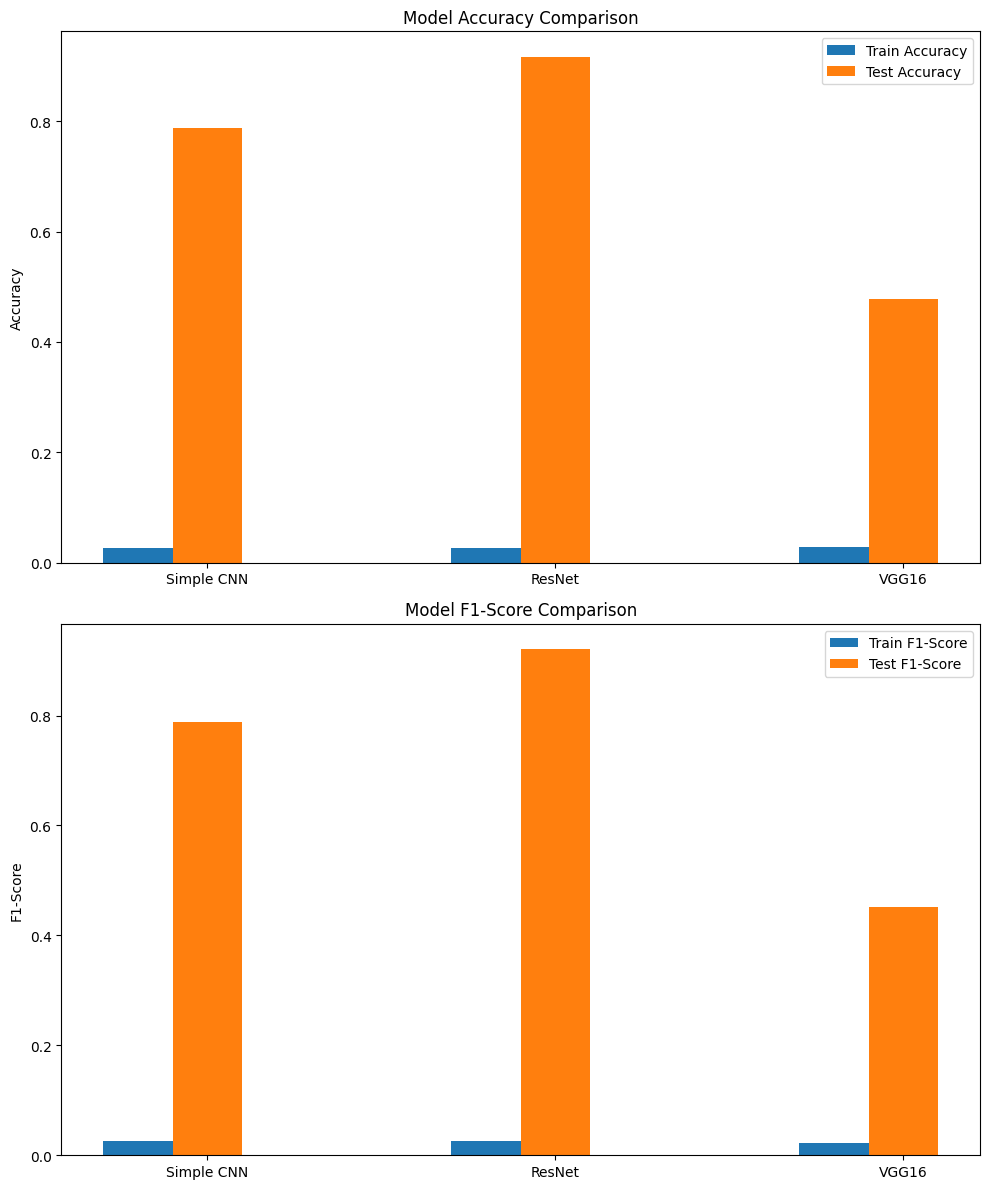

In [28]:
plot_results(results)

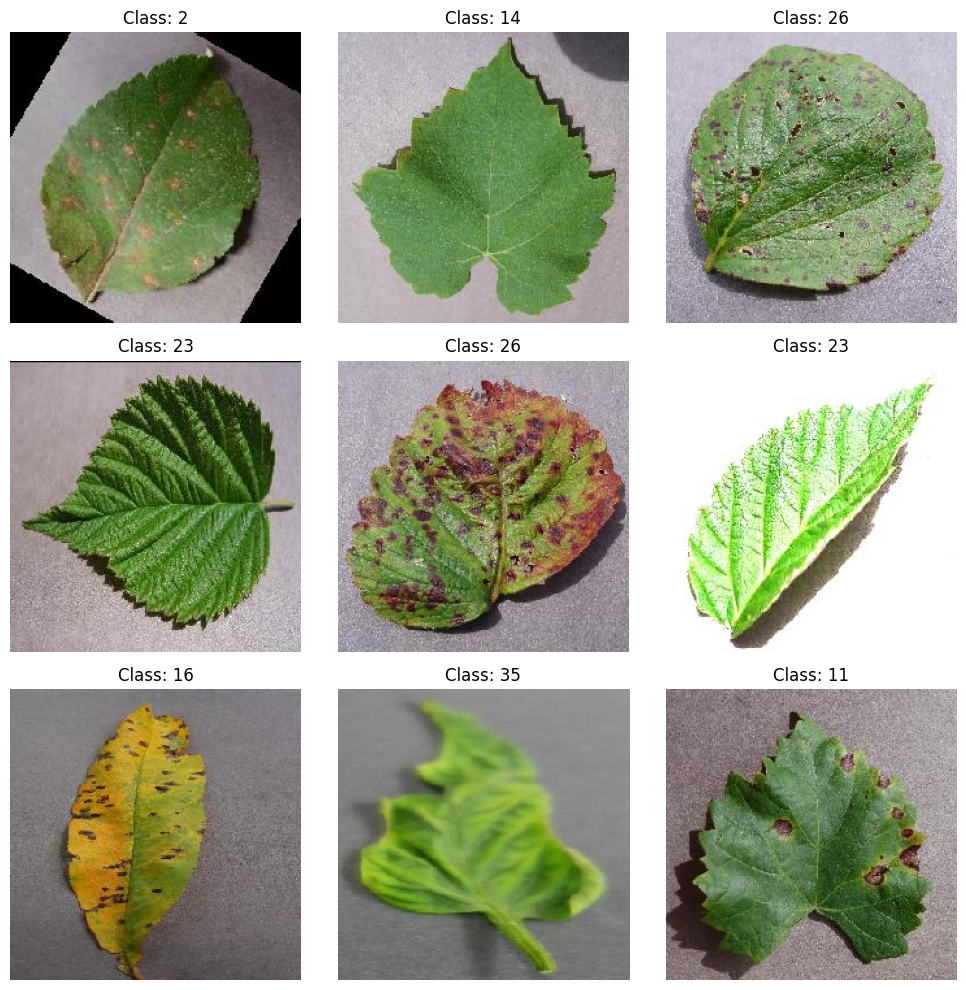

In [29]:
import matplotlib.pyplot as plt
import numpy as np


def plot_sample_images(generator):
    x_batch, y_batch = next(generator)  
    plt.figure(figsize=(10, 10))
    
    for i in range(9):  
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        plt.title(f'Class: {np.argmax(y_batch[i])}')  
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

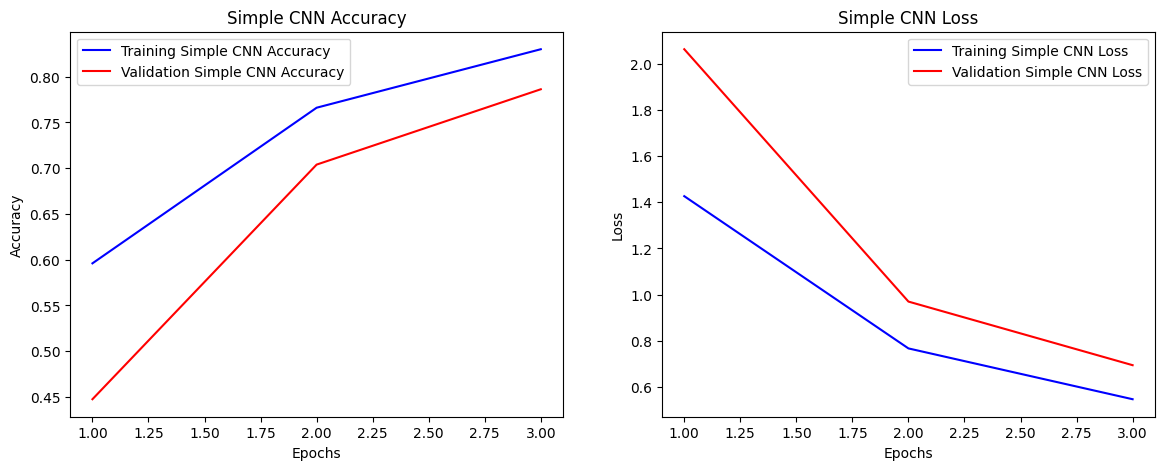

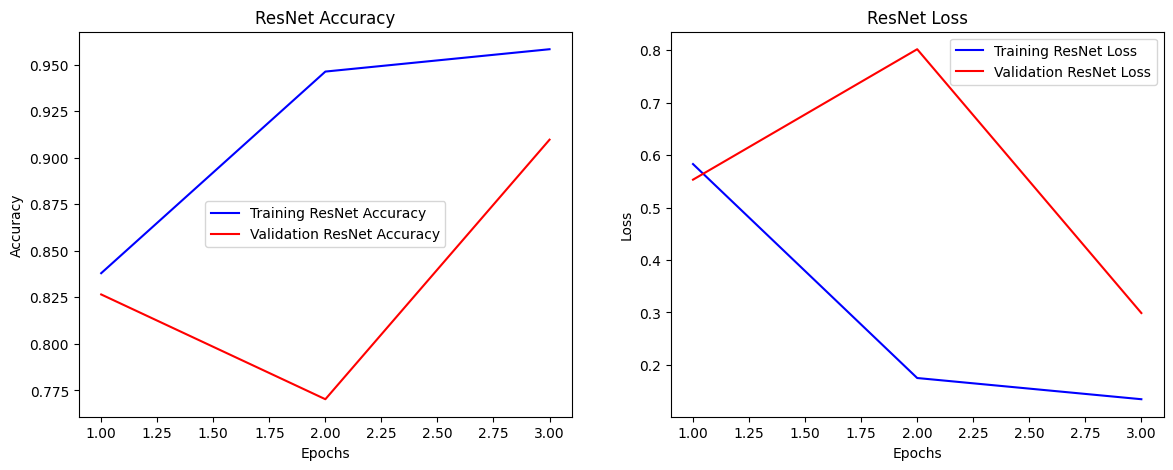

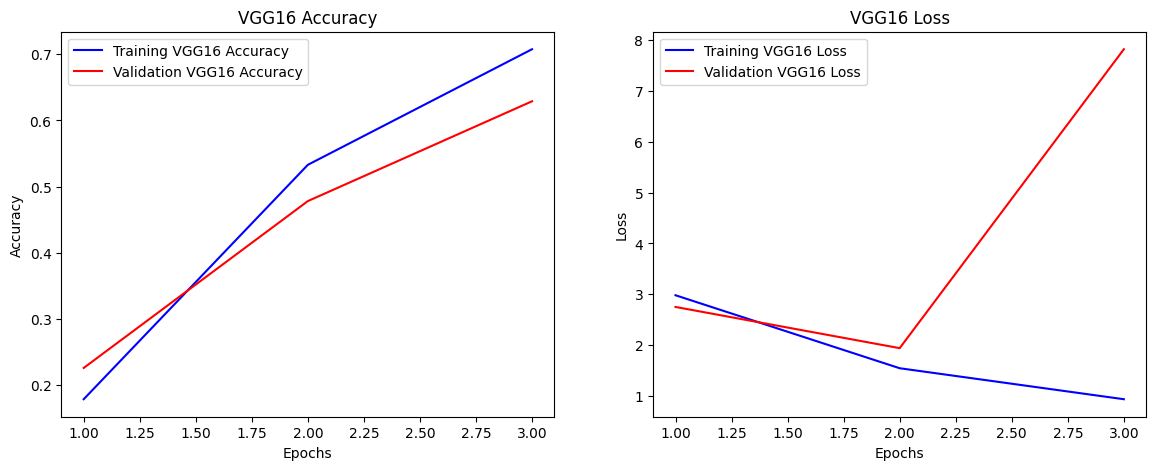

In [30]:
def plot_accuracy_loss(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label=f'Training {model_name} Accuracy')
    plt.plot(epochs, val_acc, 'r', label=f'Validation {model_name} Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label=f'Training {model_name} Loss')
    plt.plot(epochs, val_loss, 'r', label=f'Validation {model_name} Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_accuracy_loss(simple_cnn_history, 'Simple CNN')
plot_accuracy_loss(resnet_history, 'ResNet')
plot_accuracy_loss(vgg16_history, 'VGG16')
